In [1]:
from dolfin import *
import numpy as np
import ufl, time, meshio, pygmsh
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# pip install meshio

In [3]:
# !pip install gmsh


# M1: Strain based model  _______________  M2: Stress based model

In the stress based model we have to calibrate sigma_c, and in the strain based model we have to define Gc based on sigma_c so in essence we are calibrating sigma_c again.

Studies that you have to do and plot:
1. The lower bound and upper bound of Youngs modulus is [400,600]
2. Keeping E = 400, first calibrate sigma_c using M2
3. Then using the sigma_c calibrated using step2, calibrate ell using M1.
4. Then calibrate sigma_c using M1 and keep ell = 0.5
5. Repeat the above steps for E=600

Show 3 calibration values in each plot. Plot all of the above results in separate plots.

In [4]:
model = "stress_cdf"
# model = "strain_cdf"
is_adaptive = True
# is_adaptive = False

In [5]:
# ---------------------------------------------------------------------------------
# MATERIAL PARAMETERS     ------------------------------------------------
# ---------------------------------------------------------------------------------

# E0 = 600  # MPa
# sigmac = 8.3
# sigmac = 8.3

E0 = 400  # MPa
sigmac = 7.45 

if model == "stress_cdf":
    l = 0.5# 0.25, 0.75
    target_hmin = 0.1
else:
    l = 0.5 #0.5 # 0.1
    target_hmin = l/3

In [6]:
Gc = 256*sigmac**2*l/27/E0
# Gc = 0.13

---

In [7]:
import csv

In [8]:
# Specify the CSV file path
csv_file_path = "output/HA-E-"+str(E0)+"-ft-"+str(sigmac)+"-lc-"+str(l)+"_ad_"+str(is_adaptive)+"_m_"+model+".csv"
file = open(csv_file_path, mode='w', newline='')
writer = csv.writer(file)

In [9]:
comm = MPI.comm_world  # MPI communicator

In [10]:
ci = 1
nu = 0.2
mu = E0 / (2 * (1 + nu))
lmbda = E0 * nu / ((1 + nu) * (1 - 2 * nu))

# ---------------------------------------------------------------------------------
# SIMULATION PARAMETERS        ------------------------------------------------
# ---------------------------------------------------------------------------------
disp_current = 0.1 
max_disp = 0.6
deltaU = (max_disp-disp_current)/100
ms_tol = 1e-5

In [11]:
Y0 = sigmac**2/(2*E0) #Limiting crack driving energy
energy_thsd = Y0

In [12]:
27/256*E0 * Gc / sigmac ** 2

0.49999999999999994

In [13]:
256*sigmac**2*l/27/E0

0.6578074074074074

In [14]:
sigmac, Y0

(7.45, 0.06937812500000001)

In [15]:
W = 12.7
H = 2*W
L = 6*W
rod_dia = 4.7625
load_length = 0.96
support_length = 0.96
m_min = 0.1
m_max = 5

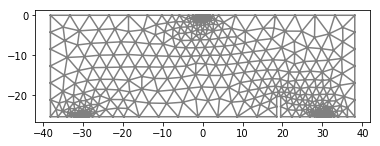

In [16]:
mesh = Mesh()
with XDMFFile("mesh/ha/mesh.xdmf") as infile:
    infile.read(mesh)

plot(mesh)

In [17]:
mesh

In [18]:
mesh.num_cells()

2131

In [19]:

# ---------------------------------------------------------------------------------
# PARAMETERS FOR PARALLEL COMPUTATIONS   -----------------------------
# ---------------------------------------------------------------------------------

rank = comm.Get_rank()  # number of current process
size = comm.Get_size()  # total number of processes


def mwrite(filename, my_list):
    MPI.barrier(comm)
    if rank == 0:
        with open(filename, "w") as f:
            for item in my_list:
                f.write("%s" % item)


def mprint(*argv):
    if rank == 0:
        out = ""
        for arg in argv:
            out = out + str(arg)
        # this forces program to output when run in parallel
        print(out, flush=True)


# ---------------------------------------------------------------------------------
# SET SOME COMMON FENICS FLAGS     ---------------------------------------
# ---------------------------------------------------------------------------------
set_log_level(50)
parameters["form_compiler"]["optimize"] = True
parameters["form_compiler"]["cpp_optimize"] = True

In [20]:
# ---------------------------------------------------------------------------------
# MATERIAL MODEL  --------------------------------------------------------
# ---------------------------------------------------------------------------------
def epsilon(u):
    return 0.5 * (grad(u) + grad(u).T)


def sigma(u):
    return 2.0 * mu * epsilon(u) + lmbda * tr(epsilon(u)) * Identity(len(u))

# -----------------------------------------------------------------------------
# 2D eigen decomposition
# -----------------------------------------------------------------------------

def get_eigenstate(t):
    eig1 = 0.5 * (tr(t) + safeSqrt(tr(t) * tr(t) - 4 * det(t)))
    eig2 = 0.5 * (tr(t) - safeSqrt(tr(t) * tr(t) - 4 * det(t)))
    return as_tensor([[eig1, 0], [0, eig2]])

# ---------------------------------------------------------------------------------
# ENERGY CALCULATIONS        ------------------------------------------------
# ---------------------------------------------------------------------------------

# Apply some scalar-to-scalar mapping `f` to each component of `T`:
def applyElementwise(f, T, dim=2):
    from ufl import shape

    if model == "stress_cdf":
        sh = shape(T)
        if len(sh) == 0:
            return f(T)
        fT = []
        for i in range(0, sh[0]):
            fT += [applyElementwise(f, T[i, i])]
        return as_tensor([[fT[0], 0], [0, fT[1]]])
    else:
        sh = shape(T)
        if len(sh) == 0:
            return f(T)
        fT = []
        for i in range(0, sh[0]):
            # if dim == 2:
            fT += [applyElementwise(f, T[i, i], dim)]
            # else:
            #     fT += [applyElementwise(f, T[i],dim)]
        return as_tensor(fT)

def split_plus_minus(T):
    x_plus = applyElementwise(lambda x: 0.5 * (abs(x) + x), T)
    x_minus = applyElementwise(lambda x: 0.5 * (abs(x) - x), T)
    return x_plus, x_minus


def safeSqrt(x):
    return sqrt(x + DOLFIN_EPS)


def get_psi(unew):
    dim = unew.function_space().mesh().topology().dim()
    strain = epsilon(unew)
    if dim == 1:
        principal_strain = strain
    else:
        principal_strain = get_eigenstate(strain)
        strain_plus, strain_minus = split_plus_minus(principal_strain)
        tr_pr_strain = tr(principal_strain)
        tr_pr_str_plus, tr_pr_str_minus = split_plus_minus(tr_pr_strain)
        si_plus = lmbda / 2 * (tr_pr_str_plus ** 2) + mu * (inner(strain_plus, strain_plus))
    return si_plus


def get_energy(unew,pnew,D):
    if model == "stress_cdf":
        # stress_plus, stress_minus = split_plus_minus(get_eigenstate(sigma(unew)))
        stress_plus = get_eigenstate(sigma(unew))
        energy_expr = ci * ((ufl.Max(stress_plus[0, 0],0)**2 + ufl.Max(stress_plus[1, 1],0)**2)/sigmac ** 2  - 1)
        energy_expr = ufl.Max(energy_expr, 0)
        energy = project(energy_expr, D, solver_type="cg",
                        preconditioner_type="hypre_euclid").vector()[:]
    else:
        dim = unew.function_space().mesh().topology().dim()
        strain = epsilon(unew)
        if dim == 1:
            principal_strain = strain
        else:
            principal_strain = get_eigenstate(strain)
            strain_plus, strain_minus = split_plus_minus(principal_strain)
            tr_pr_strain = tr(principal_strain)
            tr_pr_str_plus, tr_pr_str_minus = split_plus_minus(tr_pr_strain)
            si_plus = lmbda / 2 * (tr_pr_str_plus ** 2) + mu * (dot(strain_plus, strain_plus))
            energy = 2*l*project(si_plus, D, solver_type="cg",
                            preconditioner_type="hypre_euclid").vector()[:]/Gc
    return energy

In [21]:
#  ▄▄       ▄▄  ▄▄▄▄▄▄▄▄▄▄▄  ▄▄▄▄▄▄▄▄▄▄▄  ▄▄        ▄
# ▐░░▌     ▐░░▌▐░░░░░░░░░░░▌▐░░░░░░░░░░░▌▐░░▌      ▐░▌
# ▐░▌░▌   ▐░▐░▌▐░█▀▀▀▀▀▀▀█░▌ ▀▀▀▀█░█▀▀▀▀ ▐░▌░▌     ▐░▌
# ▐░▌▐░▌ ▐░▌▐░▌▐░▌       ▐░▌     ▐░▌     ▐░▌▐░▌    ▐░▌
# ▐░▌ ▐░▐░▌ ▐░▌▐░█▄▄▄▄▄▄▄█░▌     ▐░▌     ▐░▌ ▐░▌   ▐░▌
# ▐░▌  ▐░▌  ▐░▌▐░░░░░░░░░░░▌     ▐░▌     ▐░▌  ▐░▌  ▐░▌
# ▐░▌   ▀   ▐░▌▐░█▀▀▀▀▀▀▀█░▌     ▐░▌     ▐░▌   ▐░▌ ▐░▌
# ▐░▌       ▐░▌▐░▌       ▐░▌     ▐░▌     ▐░▌    ▐░▌▐░▌
# ▐░▌       ▐░▌▐░▌       ▐░▌ ▄▄▄▄█░█▄▄▄▄ ▐░▌     ▐░▐░▌
# ▐░▌       ▐░▌▐░▌       ▐░▌▐░░░░░░░░░░░▌▐░▌      ▐░░▌
#  ▀         ▀  ▀         ▀  ▀▀▀▀▀▀▀▀▀▀▀  ▀        ▀▀

In [22]:
xdmf = XDMFFile(comm, "output/solution2.xdmf")
xdmf.parameters["functions_share_mesh"] = False
xdmf.parameters["rewrite_function_mesh"] = True
xdmf.parameters["flush_output"] = True

In [23]:
cpp_code = """
#include <pybind11/pybind11.h>
#include <dolfin/adaptivity/adapt.h>
#include <dolfin/function/Function.h>
#include <dolfin/mesh/Mesh.h>
namespace py = pybind11;
PYBIND11_MODULE(SIGNATURE, m)
{
m.def("adapt", [](const dolfin::Function &function,
          std::shared_ptr<const dolfin::Mesh> adapted_mesh,
                  bool interpolate){
             return dolfin::adapt(function, adapted_mesh, interpolate);});
}
"""
m = compile_cpp_code(cpp_code)


def adaptFunction(f, mesh, interp=True):
    return m.adapt(f, mesh, interp)

In [24]:
def transfer(_p, mesh):
    _p = Function(adaptFunction(_p._cpp_object, mesh))
    return _p

In [25]:
def estimate(cdf_old,cdf_new):
    DG = FunctionSpace(mesh, "DG", 0)
    error_estimate = project(cdf_new - cdf_old, DG).vector()[:]
    return error_estimate

def get_markers(marker_array, mesh, phi, Y0, cdf, alpa, target_hmin, psi):
    min_achieved = False
    DG = FunctionSpace(mesh, "DG", 0)

    marker = MeshFunction("bool", mesh, mesh.topology().dim())
    marker.set_all(False)
    # ---------------------------------------------------------------------------------
    # Scheme S1    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    #  elements are refined, for which the value of error indicator is greater than α·max(error indicator)
    maximum_value = MPI.max(comm,max(marker_array))
    alpha_max = alpa * maximum_value
    marker.array()[marker_array > alpha_max] = True
    # ---------------------------------------------------------------------------------
    # Scheme S2    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    marker.array()[project(psi,DG).vector()[:] > 0.8*Y0] = True
    # marker.array()[project(psi,DG).vector()[:] < 0.8*Y0] = False
    # ---------------------------------------------------------------------------------
    # Scheme S3    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    marker.array()[project(phi,DG).vector()[:] > 0.1] = True
    # ---------------------------------------------------------------------------------
    # Scheme S4    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    cell_dia = Circumradius(mesh)
    
    dia_vector = project(cell_dia, DG, solver_type="cg",
        preconditioner_type="hypre_euclid").vector()[:]
    marker.array()[dia_vector < target_hmin] = False
    # ---------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------
    DG = None
    del DG

    min_achieved =    np.all(np.invert(marker.array()))
    return marker, min_achieved

In [26]:
def pff_problem(mesh,uold_adaptive, pold_adaptive, disp_current, ms_step,cdf_old):
    # ---------------------------------------------------------------------------------
    # FUNCTION SPACES  ---------------------------------------------------------
    # ---------------------------------------------------------------------------------
    V = VectorFunctionSpace(mesh, "CG", 1)  # displacement shape function
    D = FunctionSpace(mesh, "CG", 1)  # phase-field shape function
    # ---------------------------------------------------------------------------------
    # BOUNDARIES AND MEASURES    ------------------------------------------------
    # ---------------------------------------------------------------------------------
    load_mf = MeshFunction("size_t",mesh,1)
    load_mf.set_all(0)

    load = Expression("-t", t=disp_current, degree=1)

    fixed_pt = CompiledSubDomain("near(x[0], -30.48, support_length/2+1e-4) && near(x[1], -25.4, tol) ", tol=1e-4,support_length=support_length)
    roller_pt = CompiledSubDomain("near(x[0], 30.48, support_length/2+1e-4) && near(x[1], -25.4, tol)", tol=1e-4,support_length=support_length)

    load_face = CompiledSubDomain("near(x[0], 0, load_length/2+1e-4) && near(x[1], 0, tol)", tol=1e-14, load_length=load_length)
    load_face.mark(load_mf,6)

    bc_fixed = DirichletBC(V, Constant((0.0,0.0)), fixed_pt)
    bc_roller_1 = DirichletBC(V.sub(1), Constant(0.0), roller_pt)
    bc_load = DirichletBC(V.sub(1), load, load_face)
    bc_u = [bc_fixed,bc_roller_1,bc_load]

    bc_phi = []
    # ---------------------------------------------------------------------------------
    # FUNCTIONS    --------------------------------------------------------------
    # ---------------------------------------------------------------------------------

    u, v = TrialFunction(V), TestFunction(V)
    p, q = TrialFunction(D), TestFunction(D)

    unew, uold = Function(V, name="displacement"), Function(V)
    pnew, pold = Function(D, name="damage"), Function(D)
    cdf = Function(D, name='energy')

    # ---------------------------------------------------------------------------------
    # UPDATE FUNCTIONS    --------------------------------------------------------
    # ---------------------------------------------------------------------------------

    if step_counter > 0:
        pold.assign(project(pold_adaptive,D))
        uold.assign(project(uold_adaptive,V))

    # ---------------------------------------------------------------------------------
    # DISPLACEMENT PROBLEM      -----------------------------------------------
    # ---------------------------------------------------------------------------------
    disp_a = inner(((1 - pold) ** 2 + 1e-4) * sigma(u), epsilon(v)) * W * dx
    disp_L = inner(v, Constant((0, 0))) * dx

    # unew = Function(V, name="displacement")
    disp_problem = LinearVariationalProblem(disp_a, disp_L, unew, bc_u)
    disp_solver = LinearVariationalSolver(disp_problem)

    prm_disp = disp_solver.parameters
    prm_disp["linear_solver"] = "gmres"
    prm_disp["preconditioner"] = "hypre_euclid"
    # ---------------------------------------------------------------------------------
    # PHASE FIELD PROBLEM      -----------------------------------------------
    # ---------------------------------------------------------------------------------
    phase_a = (l**2 * inner(grad(p), grad(q)) + (1) * inner(p, q)+ cdf * inner(p, q))*dx
    phase_L = inner(cdf, q) * dx 
    phase_problem = LinearVariationalProblem(phase_a, phase_L, pnew)
    phase_solver = LinearVariationalSolver(phase_problem)

    prm_phase = phase_solver.parameters
    prm_phase["linear_solver"] = "gmres"
    prm_phase["preconditioner"] = "hypre_euclid"
    # ---------------------------------------------------------------------------------
    # START ITERATIONS    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    disp_solver.solve()
    # update history variable --------------------------------------------------
    cdf.vector().vec().array[:] = np.maximum(get_energy(unew,pnew,D)[:],cdf_old.vector()[:])
    # ToDo: kappa = np.fmax(energy, kappa)
    phase_solver.solve()
    # Clip the damage solution to 0-1 ------------------------------------------
    pnew.vector().vec().array[:] = np.clip(pnew.vector()[:], 0, 1)
    # pnew will be max(pold,pnew)-----------------------------------------------
    # pnew.vector().vec().array[:] = np.maximum(pnew.vector()[:], pold.vector()[:])
    
    # update counter -----------------------------------------------------------
    # xdmf.write(unew, step_counter)
    xdmf.write(pnew, step_counter)
    # xdmf.write(cdf, step_counter)

    # T = TensorFunctionSpace(mesh,"DG",0)
    # stress = Function(T, name="stress")
    # stress.assign(project(sigma(unew),T))
    # xdmf.write(stress, step_counter)

    err_u = sqrt(assemble((unew - uold)**2 * dx))
    err_phi = sqrt(assemble((pnew - pold)**2 * dx))
    ms_err = max(err_u, err_phi)
    # print("err - u - ", err_u, " -- err - phi - ", err_phi)
   
    
    # REACTION FORCE ------------------------------------------------------------
    residual = action(disp_a, unew) - disp_L
    v_reac = Function(V)
    bcRy = DirichletBC(V.sub(1), Constant(1.), fixed_pt)
    bcRy.apply(v_reac.vector())
    bcRy = DirichletBC(V.sub(1), Constant(1.), roller_pt)
    bcRy.apply(v_reac.vector())

    reaction = assemble(action(residual, v_reac))
    # ---------------------------------------------------------------------------
    min_ms_achieved = False
    if ms_err < ms_tol or ms_step>10 or reaction<5:
        min_ms_achieved = True
    return unew, pnew, cdf, reaction, min_ms_achieved

In [27]:
writer.writerow([0,0,0,FunctionSpace(mesh, "CG", 1).dim()*2+FunctionSpace(mesh, "DG", 0).dim()])

12

In [28]:
step_counter = 0
start = time.time()
p_adaptive = Function(FunctionSpace(mesh, "CG", 1))
unew = Function(VectorFunctionSpace(mesh, "CG", 1))
cdf_old = Function(FunctionSpace(mesh, "CG", 1), name="energy")
cdf_new = Function(FunctionSpace(mesh, "CG", 1), name="energy")

psi_old = Function(FunctionSpace(mesh, "CG", 1), name="energy")
psi_new = Function(FunctionSpace(mesh, "CG", 1), name="energy")
data_list = []
while disp_current <= max_disp:
# while time_elapsed <= 10:
    min_ms_achieved=False
    ms_step = 0
    while not min_ms_achieved:
        # ---------------------------------------------------------------------------------
        # SOLVE      -----------------------------------------------
        # ---------------------------------------------------------------------------------
        unew, p_adaptive, cdf_new, reaction, min_ms_achieved = pff_problem(mesh,unew, p_adaptive, disp_current,ms_step,cdf_old)
        psi_new.assign(project(get_psi(unew),cdf_new.function_space()))
        ms_step +=1
        if is_adaptive:
            # ESTIMATE      ----------------------------------------------
            error_estimate = estimate(psi_old,psi_new)
            # MARK     -----------------------------------------------
            marker, min_achieved = get_markers(error_estimate, mesh, p_adaptive, Y0, cdf_new, alpa=0.6, target_hmin=target_hmin, psi=psi_new)
            # REFINE      -----------------------------------------------
            mesh = refine(mesh, marker)
     
        # TRANSFER      -----------------------------------------------
        # ---------------------------------------------------------------------------------
        p_adaptive = transfer(p_adaptive, mesh)
        unew = transfer(unew, mesh)
        cdf_old.assign(transfer(cdf_new, mesh))
        psi_old.assign(transfer(psi_new, mesh))
        # ---------------------------------------------------------------------------------
        step_counter += 1
        print(
                "step: {0:5}, disp: {5:5.3f},  load: {6:5.0f}, vertices: {1:9.0f}, cells: {2:9.0f}, hmin: {3:5.2f} time: {4:6.0f}".format(
                    step_counter,
                    FunctionSpace(mesh, "CG", 1).dim(),
                    FunctionSpace(mesh, "DG", 0).dim(),
                    MPI.min(comm,mesh.hmin()),
                    time.time() - start,
                    disp_current,
                    reaction
                ),end = '\n' if min_ms_achieved else '\r'
            )
    writer.writerow([step_counter,disp_current,reaction,FunctionSpace(mesh, "CG", 1).dim()*2+FunctionSpace(mesh, "DG", 0).dim()])
    file.flush()
    disp_current += deltaU

step:     5, disp: 0.100,  load:    67, vertices:      1221, cells:      2276, hmin:  0.07 time:      1
step:     7, disp: 0.105,  load:    71, vertices:      1221, cells:      2276, hmin:  0.07 time:      1
step:     9, disp: 0.110,  load:    74, vertices:      1221, cells:      2276, hmin:  0.07 time:      2
step:    11, disp: 0.115,  load:    77, vertices:      1221, cells:      2276, hmin:  0.07 time:      2
step:    13, disp: 0.120,  load:    81, vertices:      1221, cells:      2276, hmin:  0.07 time:      2
step:    15, disp: 0.125,  load:    84, vertices:      1221, cells:      2276, hmin:  0.07 time:      3
step:    17, disp: 0.130,  load:    88, vertices:      1221, cells:      2276, hmin:  0.07 time:      3
step:    19, disp: 0.135,  load:    91, vertices:      1221, cells:      2276, hmin:  0.07 time:      3
step:    21, disp: 0.140,  load:    94, vertices:      1221, cells:      2276, hmin:  0.07 time:      4
step:    23, disp: 0.145,  load:    98, vertices:      1221, cel

KeyboardInterrupt: 